# Modeling

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMAResults
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

## Load dataframes

In [2]:
uptown = pd.read_csv('../data/uptown.csv').set_index('Unnamed: 0')
uptown.index.name = None
uptown.index = pd.to_datetime(uptown.index, format='%Y-%m')
uptown = uptown.rename(columns={'70115': 'Uptown'})


lgd = pd.read_csv('../data/lgd.csv').set_index('Unnamed: 0')
lgd.index.name = None
lgd.index = pd.to_datetime(lgd.index, format='%Y-%m')
lgd = lgd.rename(columns={'70130': 'Lower_Garden_District'})

audubon = pd.read_csv('../data/audubon.csv').set_index('Unnamed: 0')
audubon.index.name = None
audubon.index = pd.to_datetime(audubon.index, format='%Y-%m')
audubon = audubon.rename(columns={'70118': 'Audubon'})

metairie = pd.read_csv('../data/metairie.csv').set_index('Unnamed: 0')
metairie.index.name = None
metairie.index = pd.to_datetime(metairie.index, format='%Y-%m')
metairie = metairie.rename(columns={'70005': 'Metairie'})

aurora = pd.read_csv('../data/aurora.csv').set_index('Unnamed: 0')
aurora.index.name = None
aurora.index = pd.to_datetime(aurora.index, format='%Y-%m')
aurora = aurora.rename(columns={'70131': 'Aurora'})

In [3]:
aurora.head(1)

,Aurora
1996-04-01,90900.0


In [4]:
uptown.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

## Differencing periods that make each dataframe stationary

- Uptown: 1
- LGD: 2
- Audubon: 1
- Metairie: 2
- Aurora: 3

# Modeling - Uptown

In [5]:
# Note on freq: 'M' indicates the last day of month while 'MS' stands for ‘month start’.

uptown_arma = ARMA(uptown.diff(1).dropna(), order=(1,0), freq='MS')
res_arma = uptown_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")
print(f"BIC: {round(res_arma.bic, 2)}")

AIC: 4533.65
BIC: 4544.38


In [6]:
uptown_arma = ARMA(uptown.diff(1).dropna(), order=(2,1), freq='MS')
res_arma = uptown_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")
print(f"BIC: {round(res_arma.bic, 2)}")

AIC: 4392.3
BIC: 4410.18


In [7]:
uptown_arma = ARMA(uptown.diff(1).dropna(), order=(1,1), freq='MS')
res_arma = uptown_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")
print(f"BIC: {round(res_arma.bic, 2)}")

AIC: 4391.0
BIC: 4405.3


## ARIMA Modeling - Uptown

### ARIMA Manual

In [8]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# print(pdq)

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2]) for x in pdq]

pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [9]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

ans = []
lowest_aic = 10000
for comb in pdq:
    try:
        uptown_arima = sm.tsa.ARIMA(uptown, order=comb, freq='MS')
        uptown_output = uptown_arima.fit()
        ans.append([comb, uptown_output.aic])
        print('ARIMA {}: AIC Calculated = {}'.format(comb, round(output.aic, 2)))
        if uptown_output.aic < lowest_aic:
            lowest_aic = uptown_output.aic
    except:
        continue
        
print(round(lowest_aic, 4))

10000


### Auto ARIMA

#### Train test split

In [10]:
len(uptown)

265

In [11]:
265/5

53.0

In [12]:
265 - 53

212

In [13]:
uptown_train = uptown.iloc[0:212]
uptown_test = uptown.iloc[212:]

In [14]:
len(uptown_train) + len(uptown_test) == 265

True

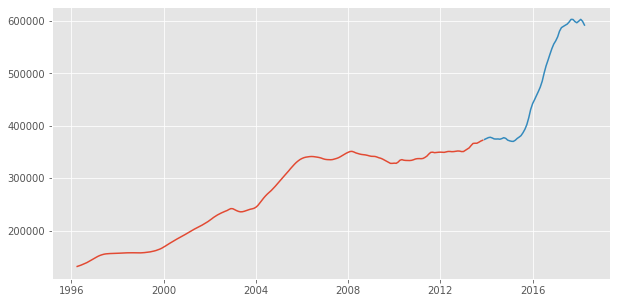

In [15]:
fig = plt.figure(figsize=(10,5))
plt.plot(uptown_train)
plt.plot(uptown_test)
plt.show()

Because the training set stops just as the test sets starts a sharp uptick, I'm going make the training set longer.

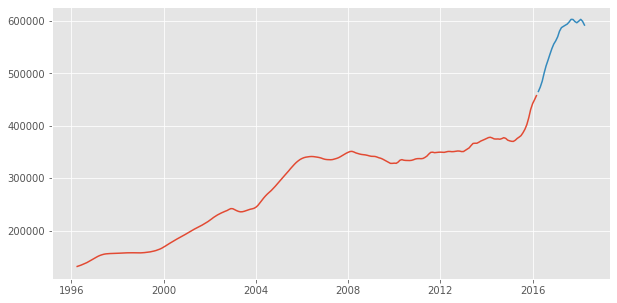

In [16]:
fig = plt.figure(figsize=(10,5))
uptown_train = uptown.iloc[0:240]
uptown_test = uptown.iloc[240:]
plt.plot(uptown_train)
plt.plot(uptown_test)
plt.show()

... a little more... Just do the last year

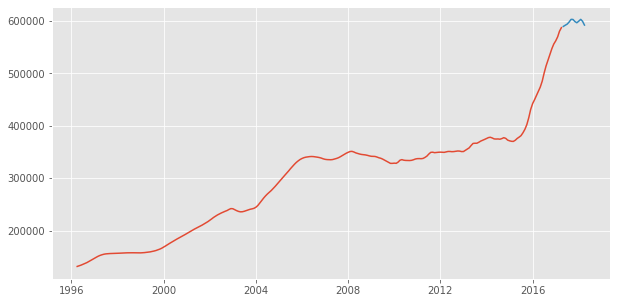

In [17]:
fig = plt.figure(figsize=(10,5))
uptown_train = uptown.iloc[0:253]
uptown_test = uptown.iloc[253:]
plt.plot(uptown_train)
plt.plot(uptown_test)
plt.show()

#### Run Auto ARIMA

In [18]:
uptown_auto_arima_train = auto_arima(uptown_train,
                               start_p=0, d=1, start_q=0,
                               max_p=4, max_d=5, max_q=5,
                               suppress_warnings=True, trace=True, stepwise=True, n_fits=20)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4751.491, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4748.285, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4727.912, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4828.363, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4673.952, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4681.995, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4680.768, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4716.557, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4728.623, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4697.785, Time=0.29 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.040 seconds


In [19]:
uptown_auto_arima_train = auto_arima(uptown_train,
                               start_p=0, d=None, start_q=0,
                               max_p=4, max_d=5, max_q=5,
                               suppress_warnings=True, trace=True, stepwise=False, n_fits=20)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4210.168, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4220.492, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4221.230, Time=0.17 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4212.790, Time=0.34 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4223.535, Time=0.13 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4220.363, Time=0.30 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4211.275, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4228.806, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=inf, Time=0.39 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=4214.914, Time=0.55 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=inf, Time=0.48 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4211.365, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=4212.412, Time=0.55 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.50 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4238.446, Time=0.66 sec
 ARIMA(3,2,0)(0,0,0)[1]  

**Auto ARIMA results:**  
My minimum AIC is 4673 for (1,1,1)  
My minimum AIC is 4210 for (0,2,0)

#### Compare with manual ARIMA on train set only

In [20]:
ans = []
lowest_aic = 10000
for comb in pdq:
    try:
        uptown_arima_train = sm.tsa.ARIMA(uptown_train, order=comb, freq='MS')
        uptown_output = uptown_arima_train.fit()
        ans.append([comb, uptown_output.aic])
        print('ARIMA {}: AIC Calculated = {}'.format(comb, round(uptown_output.aic, 2)))
        if uptown_output.aic < lowest_aic:
            lowest_aic = uptown_output.aic
    except:
        continue
        
print(round(lowest_aic, 4))

ARIMA (0, 0, 0): AIC Calculated = 6545.33
ARIMA (0, 0, 1): AIC Calculated = 6207.85
ARIMA (0, 0, 2): AIC Calculated = 5882.76
ARIMA (0, 1, 0): AIC Calculated = 4751.49
ARIMA (0, 1, 1): AIC Calculated = 4436.06
ARIMA (0, 2, 0): AIC Calculated = 4212.04
ARIMA (0, 2, 1): AIC Calculated = 4110.68
ARIMA (0, 2, 2): AIC Calculated = 4108.32
ARIMA (1, 0, 0): AIC Calculated = 4859.92
ARIMA (1, 1, 0): AIC Calculated = 4225.43
ARIMA (1, 1, 1): AIC Calculated = 4114.31
ARIMA (1, 1, 2): AIC Calculated = 4115.36
ARIMA (1, 2, 0): AIC Calculated = 4193.04
ARIMA (1, 2, 1): AIC Calculated = 4111.59
ARIMA (1, 2, 2): AIC Calculated = 4098.51
ARIMA (2, 0, 0): AIC Calculated = 4263.89
ARIMA (2, 1, 0): AIC Calculated = 4198.11
ARIMA (2, 1, 1): AIC Calculated = 4116.31
ARIMA (2, 1, 2): AIC Calculated = 4113.64
ARIMA (2, 2, 0): AIC Calculated = 4126.7
ARIMA (2, 2, 1): AIC Calculated = 4075.28
ARIMA (2, 2, 2): AIC Calculated = 4059.53
4059.5323


- Here my lowest AIC is 4059 which is ARIMA (2,2,2)
- Compared to the lowest AIC in autoARIMA, AIC is 4210 for (0,2,0).  
- Meanwhile for (2,2,2), autoARIMA doesn't even give a result ("inf").  

#### Check the models

In [21]:
uptown_output = uptown_auto_arima_train.fit(uptown_train)

print(uptown_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.11e+06   5.36e+04     20.700      0.000       1e+06    1.21e+06


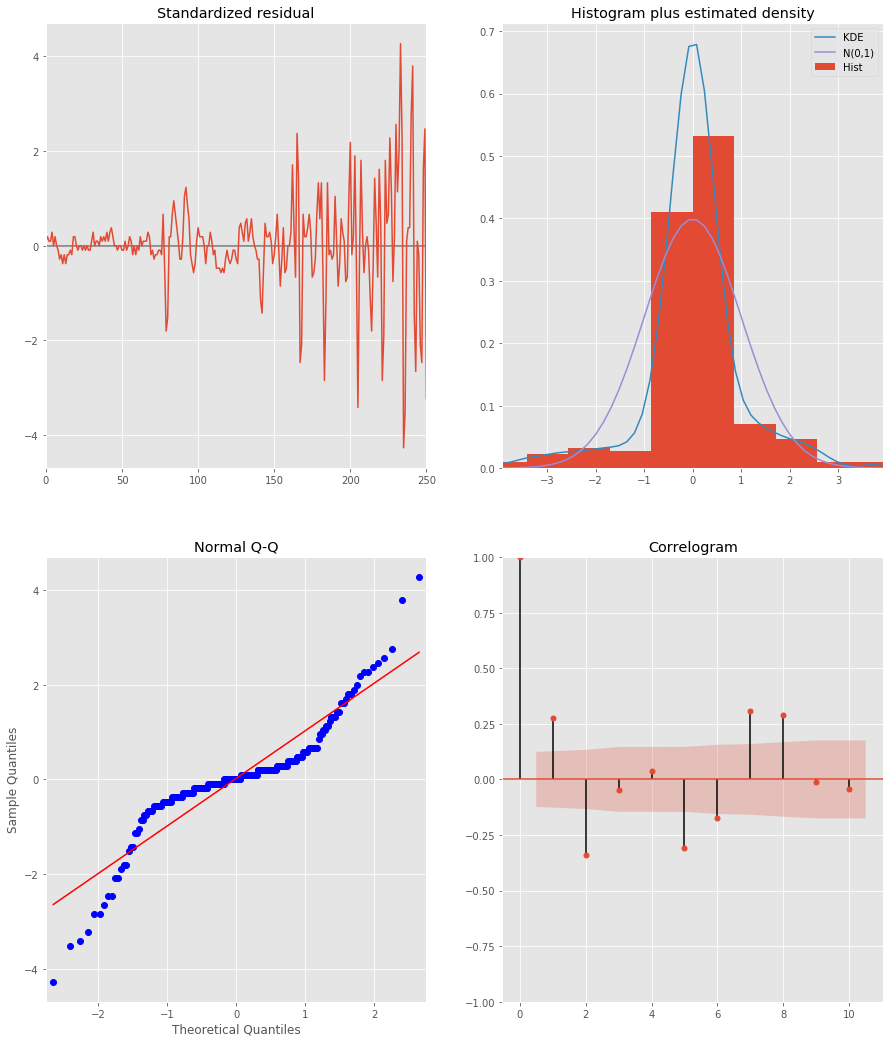

In [22]:
uptown_output.plot_diagnostics(figsize=(15, 18))
plt.show()

Not a great fit. Try the manual model (2,2,2)

In [23]:
uptown_arima = sm.tsa.ARIMA(uptown_train, order=[2,2,2])
uptown_output = uptown_arima.fit()

print(uptown_output.summary().tables[1])

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              16.0105     66.755      0.240      0.810    -114.826     146.847
ar.L1.D2.Uptown    -0.2842      0.092     -3.080      0.002      -0.465      -0.103
ar.L2.D2.Uptown    -0.5807      0.066     -8.768      0.000      -0.711      -0.451
ma.L1.D2.Uptown     1.0832      0.102     10.637      0.000       0.884       1.283
ma.L2.D2.Uptown     0.4937      0.083      5.916      0.000       0.330       0.657


In [24]:
# Note: Redoing with auto_arima because ARIMA doesn't have plot_diagnostics

uptown_arima = auto_arima(uptown_train,
                            start_p=2, d=2, start_q=2,
                            max_p=2, max_d=2, max_q=2,
                            suppress_warnings=True, trace=True, stepwise=False, n_jobs=1)

# This isn't working as I'd like it do. I want it to run just one model. 

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4210.168, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4220.492, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4221.230, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4211.275, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4228.806, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=inf, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4211.365, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=4212.412, Time=0.57 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.54 sec

Best model:  ARIMA(0,2,0)(0,0,0)[1]          
Total fit time: 1.978 seconds


#### SARIMAX for increased functionality

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3745      0.175     -2.141      0.032      -0.717      -0.032
ar.L2         -0.7302      0.144     -5.065      0.000      -1.013      -0.448
ma.L1          0.3943      0.180      2.195      0.028       0.042       0.746
ma.L2          0.7063      0.151      4.682      0.000       0.411       1.002
sigma2      6.823e+05    2.4e+04     28.458      0.000    6.35e+05    7.29e+05


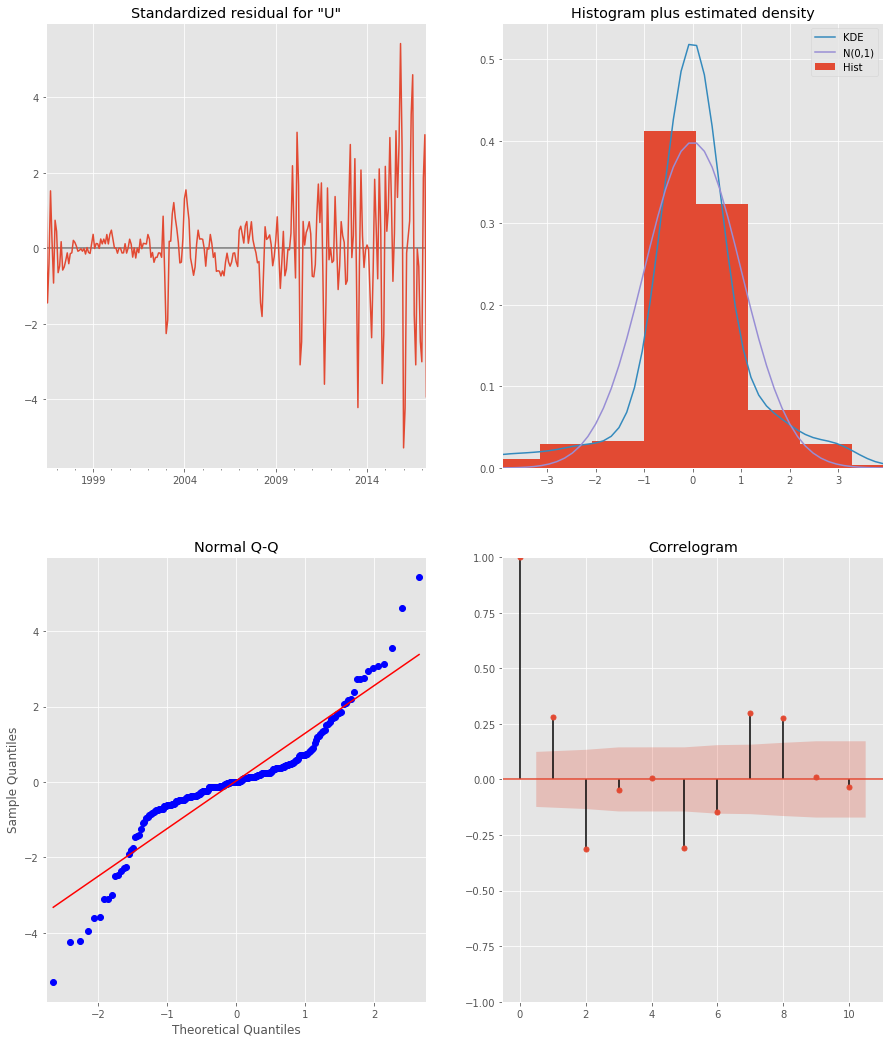

In [25]:
# Redoing parameters on SARIMAX for increased functionality

uptown_arima_smx = sm.tsa.statespace.SARIMAX(uptown_train,
                                         freq='MS',
                                        order=(2,2,2), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)
uptown_output = uptown_arima_smx.fit()
print(uptown_output.summary().tables[1])

uptown_output.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the model

### Forecasting

In [26]:
uptown_train.tail(1)

,Uptown
2017-04-01,587400.0


In [27]:
pred = uptown_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_conf = pred.conf_int()

In [28]:
uptown_output

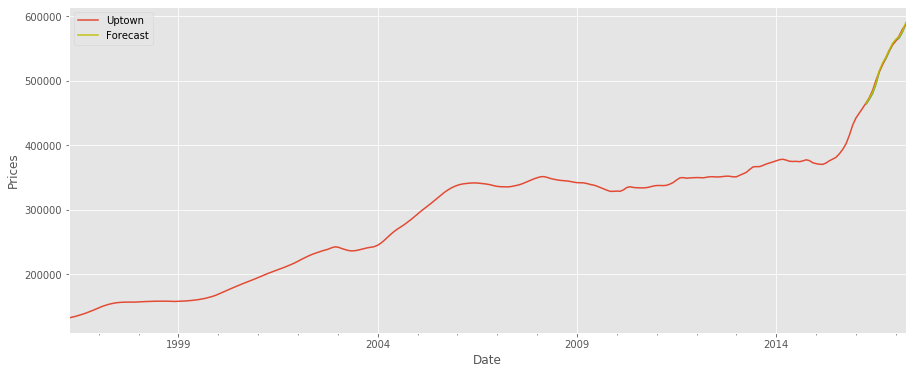

In [29]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = uptown_train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9, color='y')

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

The yellow line shows the model predicts well. 

In [30]:
# Get the real and predicted values
uptown_train_forecasted = pred.predicted_mean
uptown_train_truth = uptown_train['2016-04-01':]

rms = mean_squared_error(uptown_train_truth, uptown_train_forecasted, squared=False)
round(rms, 2)

2178.03

### Dynamic Forecasting

In [31]:
pred_dynamic = uptown_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [32]:
uptown_output

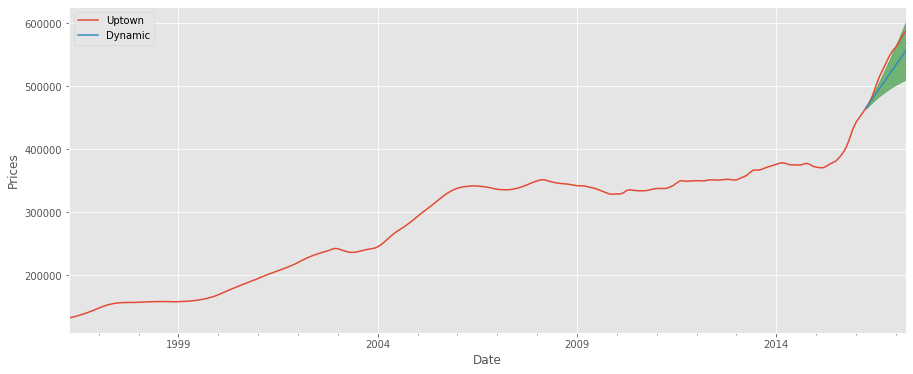

In [33]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = uptown_train.plot(label='uptown')

# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic')

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

### RMSE

In [34]:
uptown_test.head(1)

,Uptown
2017-05-01,589700.0


In [35]:
uptown_test.tail(1)

,Uptown
2018-04-01,592300.0


In [36]:
# RMSE on the Forecasted (not dynamic) to compare with test set
forecast = uptown_output.forecast(steps=12)

rms = mean_squared_error(uptown_test, forecast, squared=False)
round(rms, 2)

42103.65

## Producing Forecasts

In [37]:
# Get forecast 24 steps ahead in future
prediction = uptown_output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

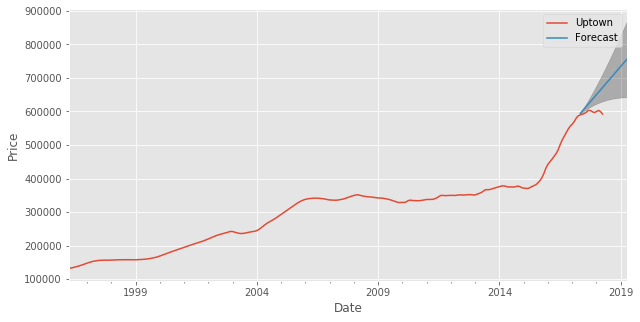

In [38]:
ax = uptown.plot(label='observed', figsize=(10,5))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

# Modeling - Lower Garden District

## Baseline

In [39]:
lgd_arma = ARMA(lgd.diff(2).dropna(), order=(1,0), freq='MS')
res_arma = lgd_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")


# This one doesn't work. Throws an error.

# lgd_arma = ARMA(lgd.diff(2).dropna(), order=(2,1), freq='MS')
# res_arma = lgd_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

# This one doesn't work. Throws an error.

# lgd_arma = ARMA(lgd.diff(2).dropna(), order=(1,1), freq='MS')
# res_arma = lgd_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

AIC: 4917.31


Baseline is (1,0) with AIC of 4917

## Auto ARIMA

### Train Test Split

Just going with 12 months of test data

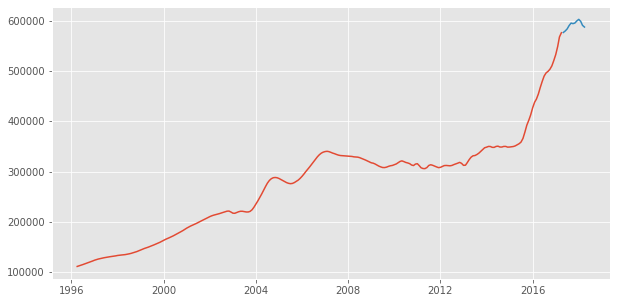

In [40]:
fig = plt.figure(figsize=(10,5))
lgd_train = lgd.iloc[0:253]
lgd_test = lgd.iloc[253:]
plt.plot(lgd_train)
plt.plot(lgd_test)
plt.show()

### Run Auto ARIMA

In [41]:
lgd_auto_arima_train = auto_arima(lgd_train,
                               start_p=0, d=None, start_q=0,
                               max_p=4, max_d=5, max_q=5,
                               suppress_warnings=True, trace=True, stepwise=False, n_fits=20)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4396.317, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4400.078, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4404.387, Time=0.11 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4410.157, Time=0.08 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4406.949, Time=0.14 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4406.589, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4396.947, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4402.564, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=inf, Time=0.36 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=4399.941, Time=0.53 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4409.109, Time=0.31 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4410.880, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=0.40 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=inf, Time=0.52 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4409.766, Time=0.67 sec
 ARIMA(3,2,0)(0,0,0)[1]  

#### Check the model

In [42]:
lgd_output = lgd_auto_arima_train.fit(lgd_train)

print(lgd_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.33e+06   8.44e+04     27.614      0.000    2.16e+06     2.5e+06


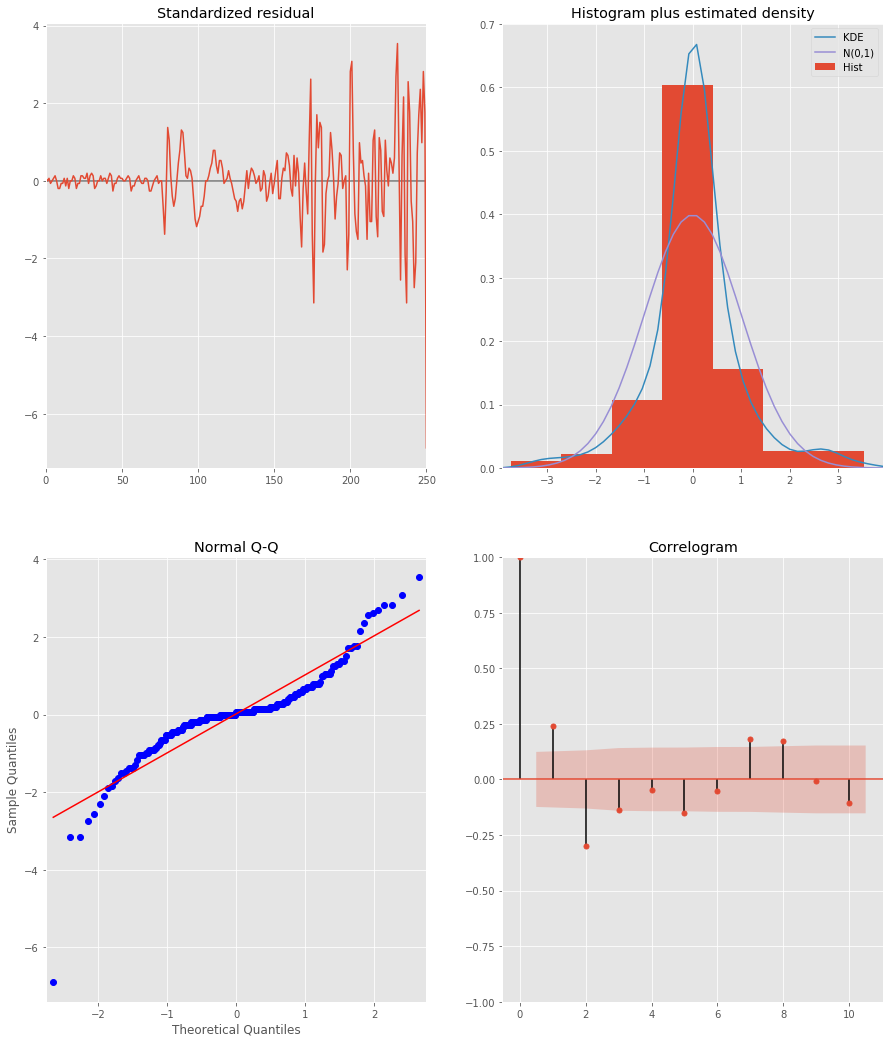

In [43]:
lgd_output.plot_diagnostics(figsize=(15, 18))
plt.show()

#### SARIMAX for increased functionality

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.33e+06   8.44e+04     27.614      0.000    2.16e+06     2.5e+06


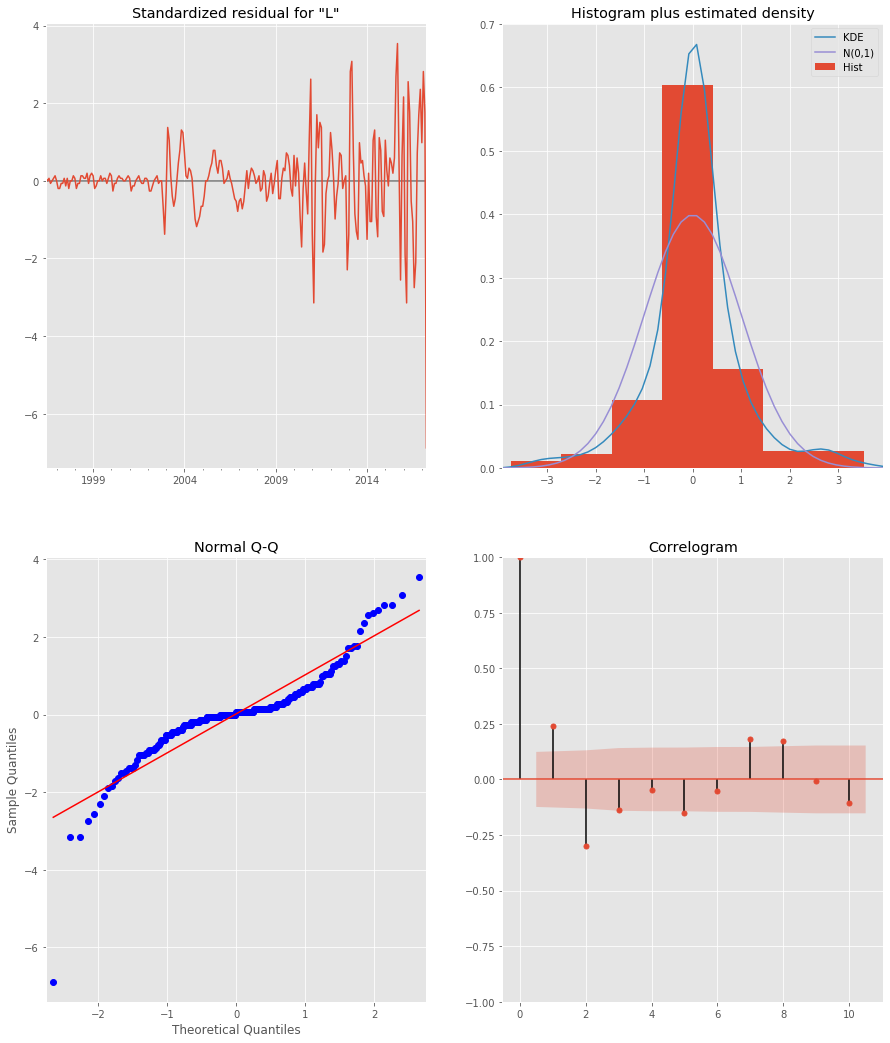

In [44]:
lgd_arima_smx = sm.tsa.statespace.SARIMAX(lgd_train,
                                      order=(0,2,0), 
                                      freq='MS',
                                      enforce_stationarity=True, 
                                      enforce_invertibility=False)
lgd_output = lgd_arima_smx.fit()
print(lgd_output.summary().tables[1])

lgd_output.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the model

### Forecasting

In [45]:
pred = lgd_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_conf = pred.conf_int()

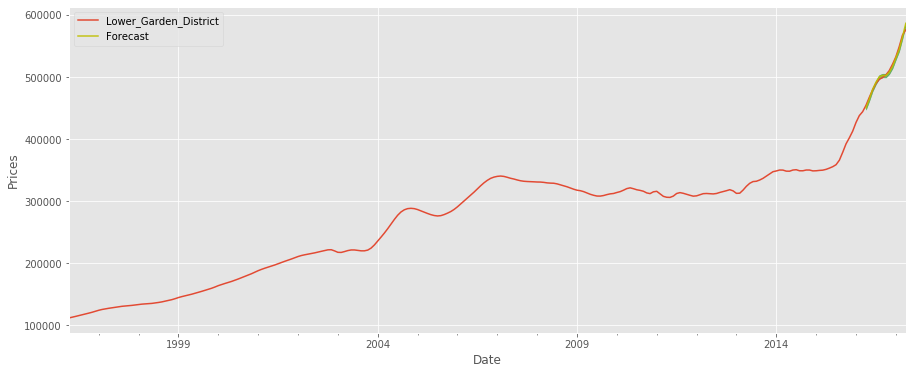

In [46]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = lgd_train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9, color='y')

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

The yellow line shows a pretty good fit, but not as good as uptown

In [47]:
# RMSE
lgd_train_forecasted = pred.predicted_mean
lgd_train_truth = lgd_train['2016-04-01':]

rms = mean_squared_error(lgd_train_truth, lgd_train_forecasted, squared=False)
round(rms, 2)

4045.8

### Dynamic Forecasting

In [48]:
lgd_output

In [49]:
pred_dynamic = lgd_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [50]:
lgd_train_forecasted = pred_dynamic.predicted_mean
lgd_train_truth = lgd_train['2016-04-01':]

rms = mean_squared_error(lgd_train_truth, lgd_train_forecasted, squared=False)
round(rms, 2)

26437.4

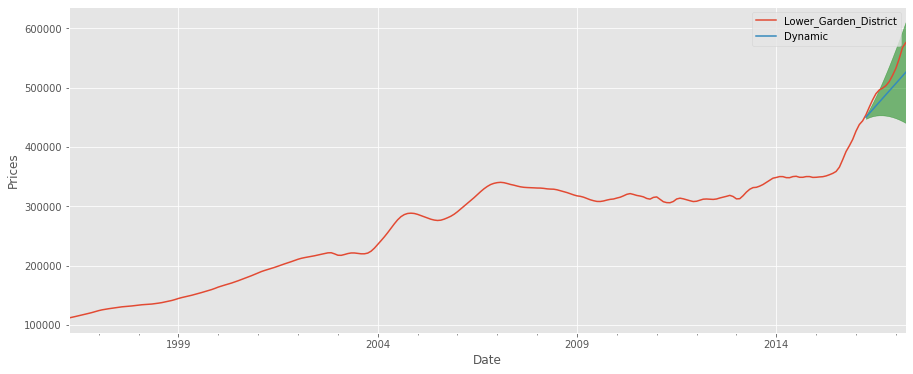

In [51]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = lgd_train.plot(label='lgd')

# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic')

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

Dynamic forecast seems a little lower than basic forecast

### RMSE

In [52]:
# RMSE on the Forecasted (not dynamic) to compare with test set
forecast = lgd_output.forecast(steps=12)

rms = mean_squared_error(lgd_test, forecast, squared=False)
round(rms, 2)

46788.33

## Producing Forecasts

In [53]:
# Get forecast 24 steps ahead in future
prediction = lgd_output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

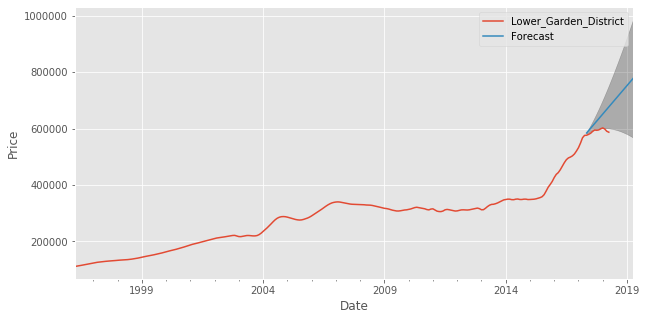

In [54]:

ax = lgd.plot(label='observed', figsize=(10,5))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

# Modeling - Audubon

## Baseline

In [55]:
audubon_arma = ARMA(audubon.diff(1).dropna(), order=(1,0), freq='MS')
res_arma = audubon_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

audubon_arma = ARMA(audubon.diff(1).dropna(), order=(2,1), freq='MS')
res_arma = audubon_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

audubon_arma = ARMA(audubon.diff(1).dropna(), order=(1,1), freq='MS')
res_arma = audubon_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

AIC: 4412.73
AIC: 4280.07
AIC: 4287.45


Baseline is (2,1) with AIC of 4280

## Auto ARIMA

### Train Test Split

Just going with 12 months of test data

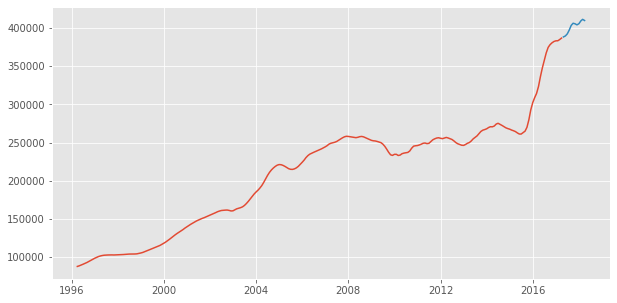

In [56]:
fig = plt.figure(figsize=(10,5))
audubon_train = audubon.iloc[0:253]
audubon_test = audubon.iloc[253:]
plt.plot(audubon_train)
plt.plot(audubon_test)
plt.show()

### Run Auto ARIMA

In [57]:
audubon_auto_arima_train = auto_arima(audubon_train,
                               start_p=0, d=None, start_q=0,
                               max_p=4, max_d=5, max_q=5,
                               suppress_warnings=True, trace=True, stepwise=False, n_fits=20)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=4621.068, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=4586.525, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=4570.955, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=4572.513, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=4577.307, Time=0.12 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=4578.979, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=4575.990, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=4547.997, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=4549.649, Time=0.57 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=4550.549, Time=1.01 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=4570.559, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=4706.145, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=4592.871, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=5062.341, Time=0.83 sec
 ARIMA(3,1,0)(0

Here (1,1,2) gets me a worse AIC of 4548, but this is only on the train set.

**Test out baseline model on train set**

In [58]:
audubon_arma = ARMA(audubon_train.diff(1).dropna(), order=(1,0), freq='MS')
res_arma = audubon_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

audubon_arma = ARMA(audubon_train.diff(1).dropna(), order=(2,1), freq='MS')
res_arma = audubon_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

audubon_arma = ARMA(audubon_train.diff(1).dropna(), order=(1,1), freq='MS')
res_arma = audubon_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

AIC: 4166.14
AIC: 4052.81
AIC: 4055.19


Still the (2,1) is much better with an AIC of 4053.

#### Check the model

**This is the autoARIMA model**

In [59]:
audubon_output = audubon_auto_arima_train.fit(audubon_train)

print(audubon_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    295.8209     92.634      3.193      0.001     114.262     477.380
ar.L1          0.7242      0.055     13.145      0.000       0.616       0.832
ma.L1         -0.6004      0.057    -10.607      0.000      -0.711      -0.489
ma.L2          0.0158      0.013      1.223      0.221      -0.010       0.041
sigma2      3.522e+06      0.019    1.9e+08      0.000    3.52e+06    3.52e+06


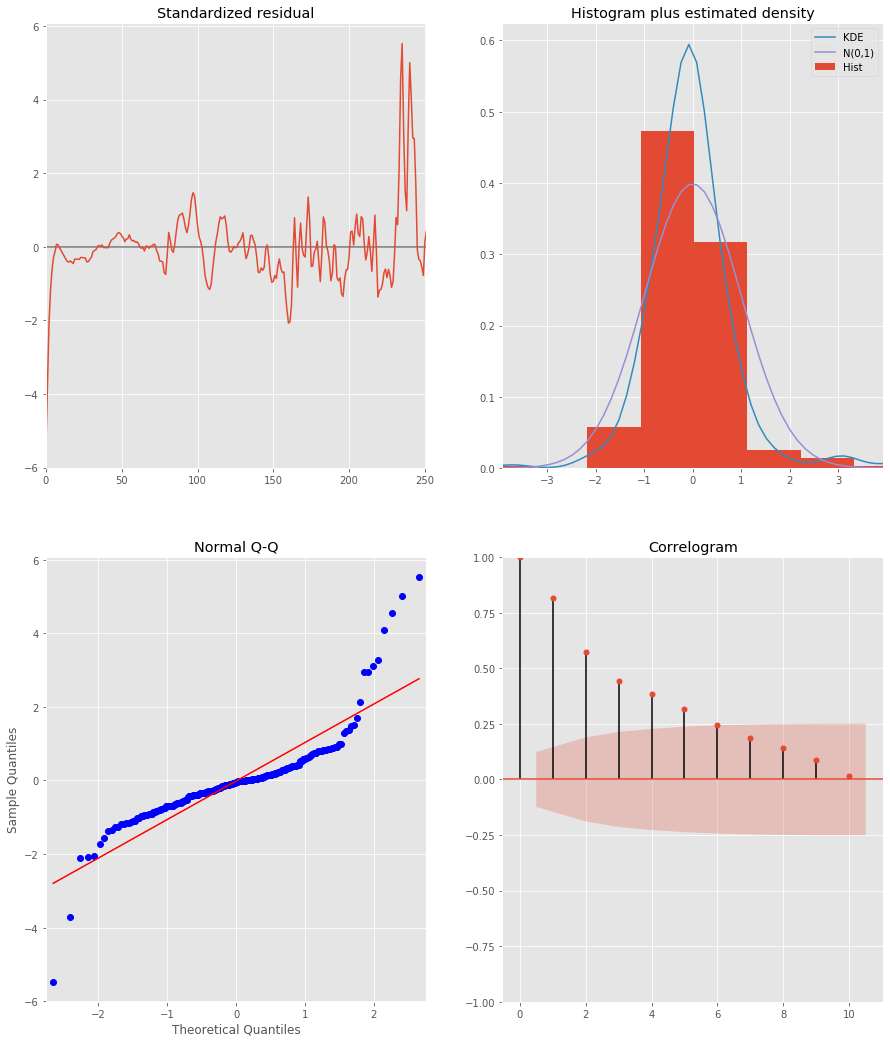

In [60]:
audubon_output.plot_diagnostics(figsize=(15, 18))
plt.show()

**Check out my baseline model with SARIMAX**

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1862      0.013    -14.462      0.000      -0.211      -0.161
ar.L2          0.1945      0.010     19.126      0.000       0.175       0.214
ma.L1          2.5536      0.061     42.010      0.000       2.434       2.673
sigma2      1.655e+06   4.78e-08   3.46e+13      0.000    1.66e+06    1.66e+06


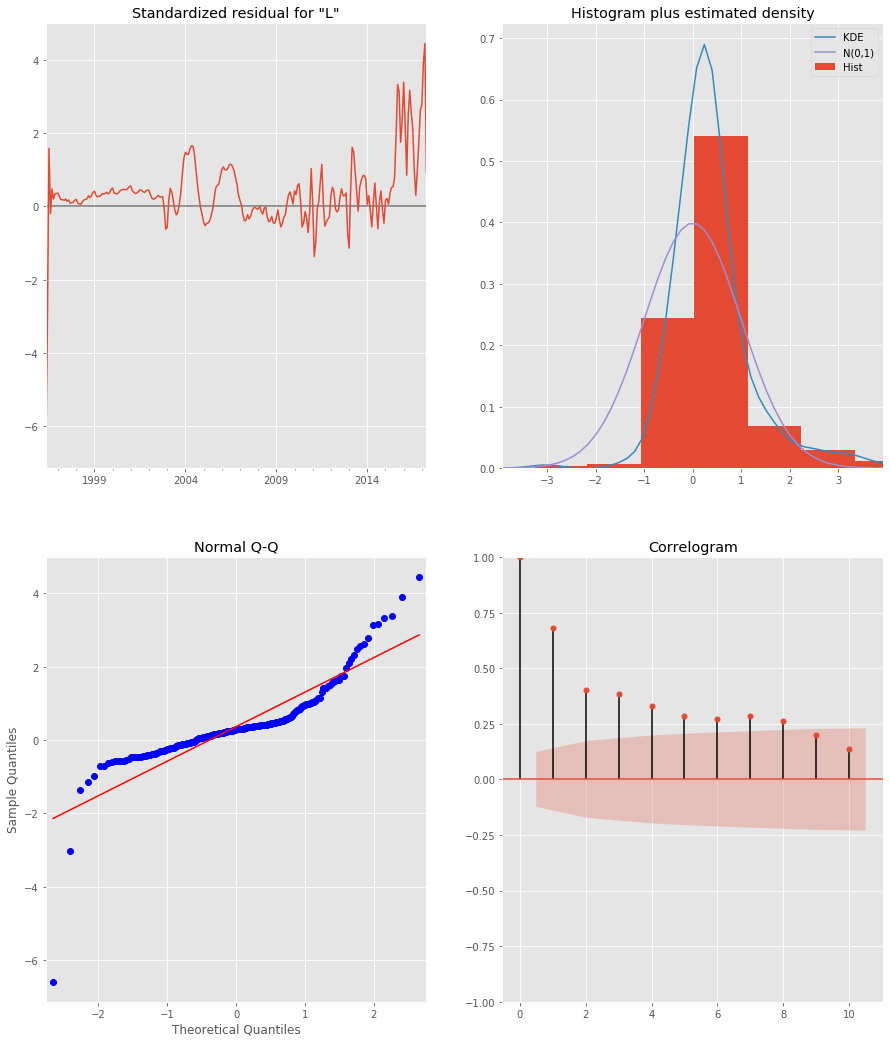

In [61]:
audubon_arima_smx = sm.tsa.statespace.SARIMAX(lgd_train,
                                      order=(2,1,1), 
                                      freq='MS',
                                      enforce_stationarity=True, 
                                      enforce_invertibility=False)
audubon_output = audubon_arima_smx.fit()
print(audubon_output.summary().tables[1])

audubon_output.plot_diagnostics(figsize=(15, 18))
plt.show()

**It doesn't look better even though its AIC is lower. I'm going to stick with the autoARIMA one**

#### SARIMAX for increased functionality

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9991      0.003    388.145      0.000       0.994       1.004
ma.L1          3.5912      0.093     38.627      0.000       3.409       3.773
ma.L2         -4.5621      0.071    -64.171      0.000      -4.701      -4.423
sigma2       4.59e+05   6.11e-07   7.52e+11      0.000    4.59e+05    4.59e+05


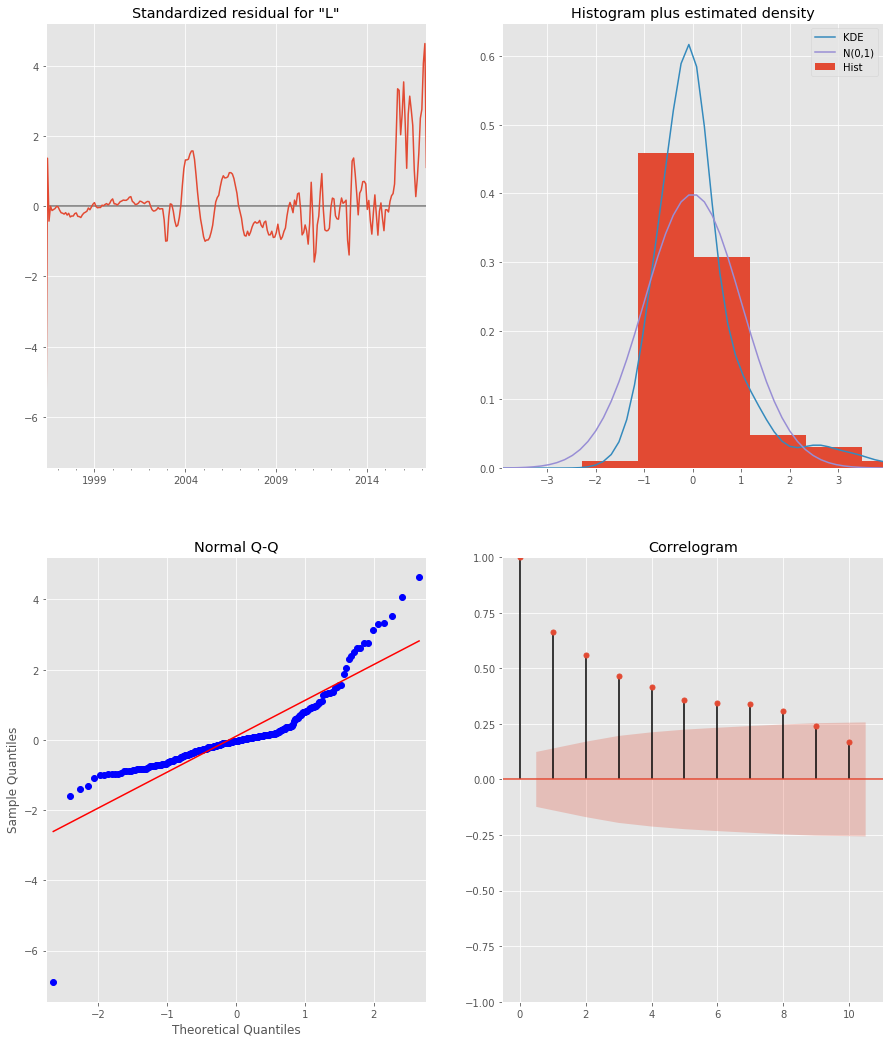

In [62]:
audubon_arima_smx = sm.tsa.statespace.SARIMAX(lgd_train,
                                      order=(1,1,2), 
                                      freq='MS',
                                      enforce_stationarity=True, 
                                      enforce_invertibility=False)
audubon_output = audubon_arima_smx.fit()
print(audubon_output.summary().tables[1])

audubon_output.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the model

### Forecasting

In [63]:
pred = audubon_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_conf = pred.conf_int()

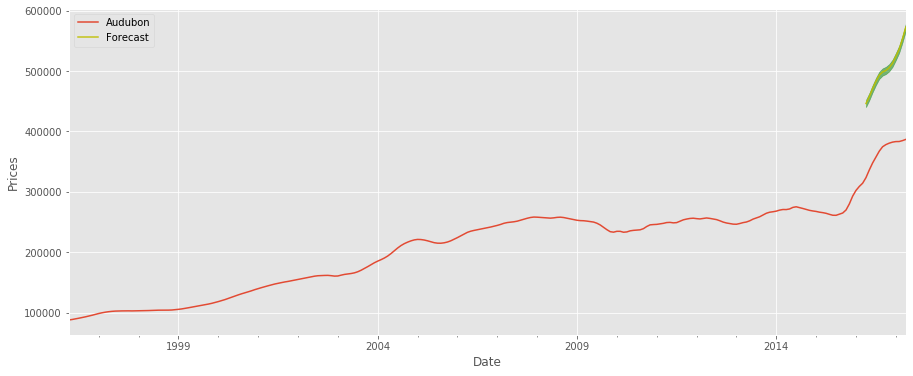

In [64]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = audubon_train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9, color='y')

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

The yellow line shows a poor fit. Strange how it doesn't even start at the right place.

In [65]:
# RMSE
audubon_train_forecasted = pred.predicted_mean
audubon_train_truth = lgd_train['2016-04-01':]

rms = mean_squared_error(audubon_train_truth, audubon_train_forecasted, squared=False)
round(rms, 2)

8023.76

### Dynamic Forecasting

In [66]:
audubon_output

In [67]:
pred_dynamic = audubon_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [68]:
audubon_train_forecasted = pred_dynamic.predicted_mean
audubon_train_truth = audubon_train['2016-04-01':]

rms = mean_squared_error(audubon_train_truth, audubon_train_forecasted, squared=False)
round(rms, 2)

87464.14

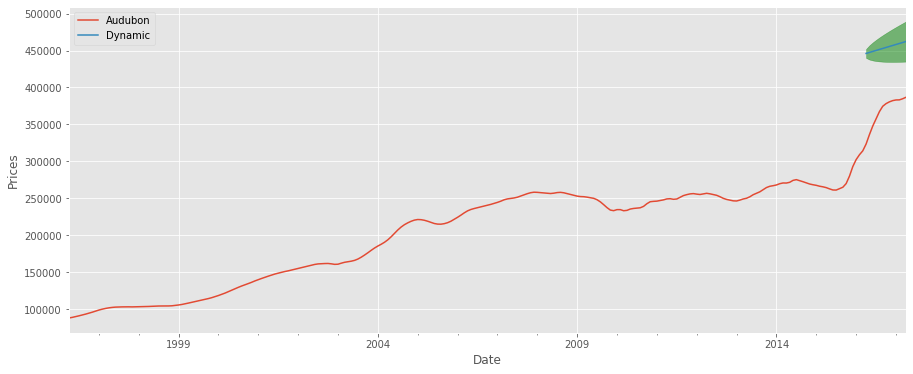

In [69]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = audubon_train.plot()

# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic')

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

Dynamic forecast seems off.

### RMSE

In [70]:
# RMSE on the Forecasted (not dynamic) to compare with test set
forecast = audubon_output.forecast(steps=12)

rms = mean_squared_error(audubon_test, forecast, squared=False)
round(rms, 2)

186895.73

## Producing Forecasts

In [71]:
# Get forecast 24 steps ahead in future
prediction = audubon_output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

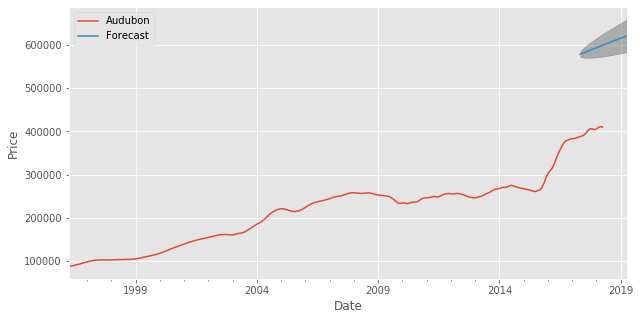

In [72]:

ax = audubon.plot(label='observed', figsize=(10,5))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

# Modeling - Metairie

## Baseline

In [80]:
# These don't work. Throws an error.

# metairie_arma = ARMA(metairie.diff(2).dropna(), order=(1,0), freq='MS')
# res_arma = metairie_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

# metairie_arma = ARMA(metairie.diff(2).dropna(), order=(2,1), freq='MS')
# res_arma = metairie_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")


# metairie_arma = ARMA(metairie.diff(2).dropna(), order=(1,1), freq='MS')
# res_arma = metairie_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

metairie_arma = ARMA(metairie.diff(2).dropna(), order=(0,1), freq='MS')
res_arma = metairie_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

metairie_arma = ARMA(metairie.diff(2).dropna(), order=(1,2), freq='MS')
res_arma = metairie_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")


metairie_arma = ARMA(metairie.diff(2).dropna(), order=(2,2), freq='MS')
res_arma = metairie_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC: 4558.83
AIC: 3939.84
AIC: 3939.62


Baseline is (2,2) with AIC of 3939.6

## Auto ARIMA

### Train Test Split

Just going with 12 months of test data

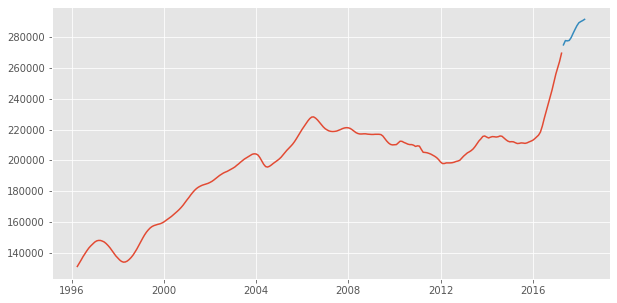

In [81]:
fig = plt.figure(figsize=(10,5))
metairie_train = metairie.iloc[0:253]
metairie_test = metairie.iloc[253:]
plt.plot(metairie_train)
plt.plot(metairie_test)
plt.show()

In [82]:
len(metairie_train) + len(metairie_test) == len(metairie)

True

Looks like there's a gap in the graph but the length of the df's are correct.

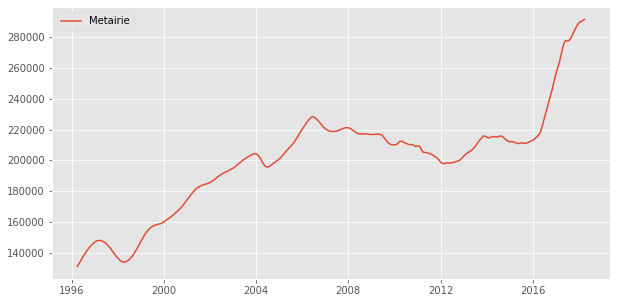

In [84]:
plt.figure(figsize=(10,5))
plt.plot(metairie)
plt.legend(metairie.columns)
plt.show()

### Run Auto ARIMA

In [85]:
metairie_auto_arima_train = auto_arima(metairie_train,
                               start_p=0, d=None, start_q=0,
                               max_p=4, max_d=5, max_q=5,
                               suppress_warnings=True, trace=True, stepwise=False, n_fits=20)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=4348.292, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=4329.235, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=4314.782, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=4303.857, Time=0.24 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=4299.048, Time=0.33 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=4301.391, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=4327.522, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=4279.708, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=4287.444, Time=1.07 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=4284.892, Time=1.05 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=4282.020, Time=1.01 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=4312.138, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=4287.838, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=4513.718, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=4622.318, Time=1.05 sec
 ARIMA(3,1

- Curious how 'metairie' requried a differencing of at least 2 to pass Dickey Fuller test, but here it passes with (1,1,1)  
- The best model results have higher AIC than my baseline model (which had a different _d_.) 

#### Check the model

In [86]:
metairie_output = metairie_auto_arima_train.fit(metairie_train)

print(metairie_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     99.2695     30.983      3.204      0.001      38.544     159.995
ar.L1          0.7669      0.038     20.218      0.000       0.693       0.841
ma.L1         -0.6816      0.040    -16.893      0.000      -0.761      -0.602
sigma2      1.044e+06    7.8e-05   1.34e+10      0.000    1.04e+06    1.04e+06


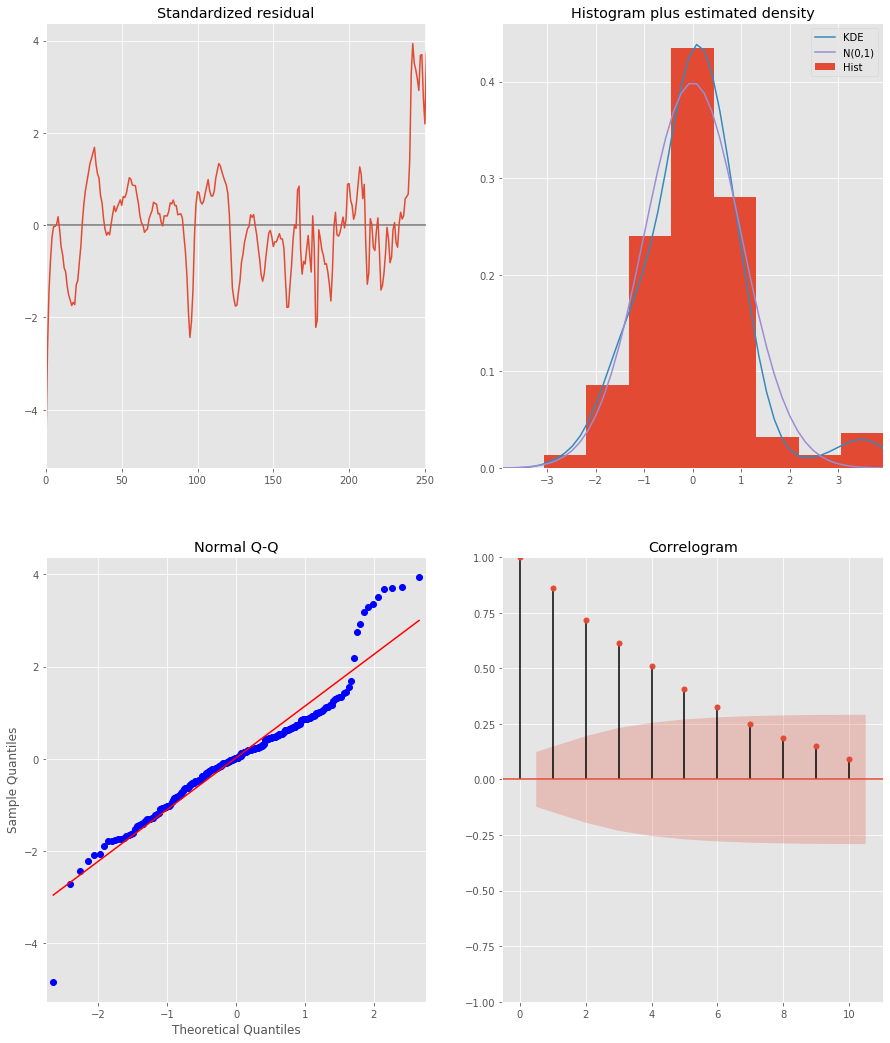

In [87]:
metairie_output.plot_diagnostics(figsize=(15, 18))
plt.show()

Results look OK here, especially the histogram with well matching lines. 

#### SARIMAX for increased functionality

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8272      0.023     36.689      0.000       0.783       0.871
ma.L1         -1.3354      0.042    -31.676      0.000      -1.418      -1.253
sigma2      6.832e+05   4.24e-08   1.61e+13      0.000    6.83e+05    6.83e+05


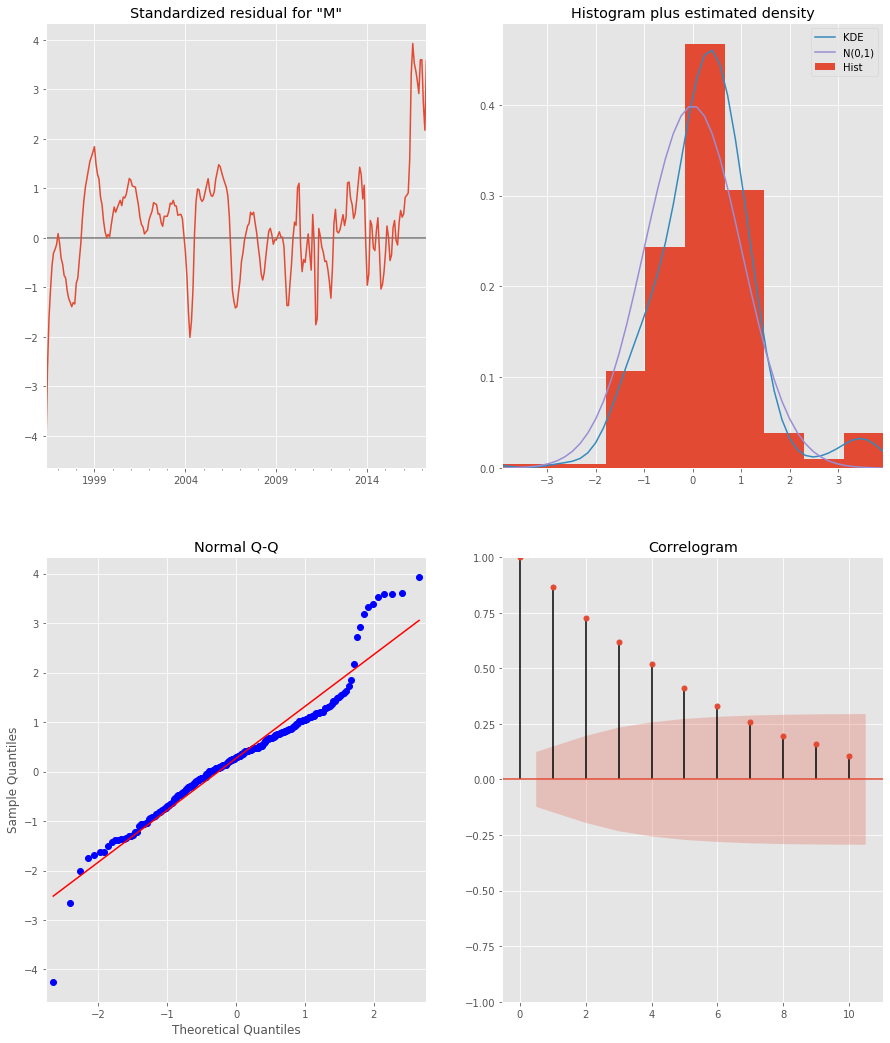

In [88]:
metairie_arima_smx = sm.tsa.statespace.SARIMAX(metairie_train,
                                      order=(1,1,1), 
                                      freq='MS',
                                      enforce_stationarity=True, 
                                      enforce_invertibility=False)
metairie_output = metairie_arima_smx.fit()
print(metairie_output.summary().tables[1])

metairie_output.plot_diagnostics(figsize=(15, 18))
plt.show()

Graphs look similar, but the SARIMAX version of the histogram is a _little_ different.

## Validating the model

### Forecasting

In [89]:
pred = metairie_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_conf = pred.conf_int()

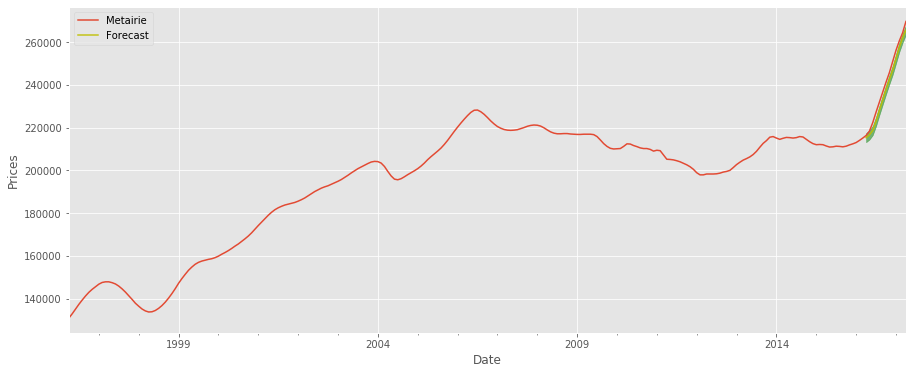

In [90]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = metairie_train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9, color='y')

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

The yellow line shows a good fit.

In [91]:
# RMSE
metairie_train_forecasted = pred.predicted_mean
metairie_train_truth = metairie_train['2016-04-01':]

rms = mean_squared_error(metairie_train_truth, metairie_train_forecasted, squared=False)
round(rms, 2)

3394.47

### Dynamic Forecasting

In [92]:
metairie_output

In [93]:
pred_dynamic = metairie_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [94]:
metairie_train_forecasted = pred_dynamic.predicted_mean
metairie_train_truth = metairie_train['2016-04-01':]

rms = mean_squared_error(metairie_train_truth, metairie_train_forecasted, squared=False)
round(rms, 2)

30812.06

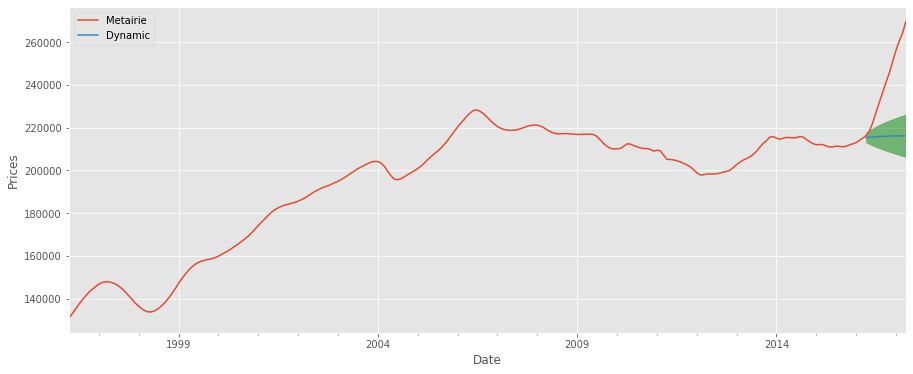

In [95]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = metairie_train.plot(label='metairie')

# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic')

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

Dynamic forecast is much worse than basic forecast and a much higher (worse) RMSE.

### RMSE

In [96]:
# RMSE on the Forecasted (not dynamic) to compare with test set
forecast = metairie_output.forecast(steps=12)

rms = mean_squared_error(metairie_test, forecast, squared=False)
round(rms, 2)

9778.85

## Producing Forecasts

In [53]:
# Get forecast 24 steps ahead in future
prediction = metairie_output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

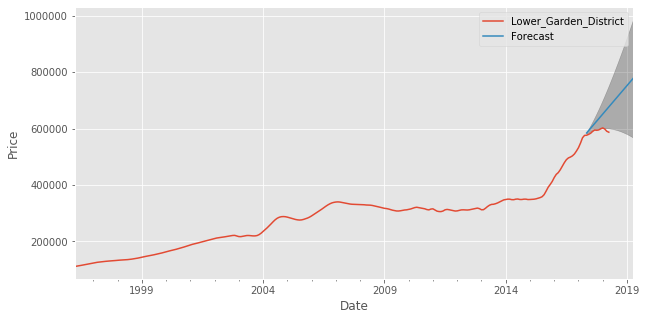

In [54]:

ax = metairie.plot(label='observed', figsize=(10,5))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

# Modeling - Aurora

## Baseline

In [102]:
aurora_arma = ARMA(aurora.diff(3).dropna(), order=(1,0), freq='MS')
res_arma = aurora_arma.fit()

print(f"AIC: {round(res_arma.aic, 2)}")


# This one doesn't work. Throws an error.

# aurora_arma = ARMA(aurora.diff(3).dropna(), order=(2,1), freq='MS')
# res_arma = aurora_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

# This one doesn't work. Throws an error.

# aurora_arma = ARMA(aurora.diff(3).dropna(), order=(1,1), freq='MS')
# res_arma = aurora_arma.fit()

# print(f"AIC: {round(res_arma.aic, 2)}")

AIC: 4296.81


Baseline is (1,0) with AIC of 4296.81

## Auto ARIMA

### Train Test Split

Just going with 12 months of test data

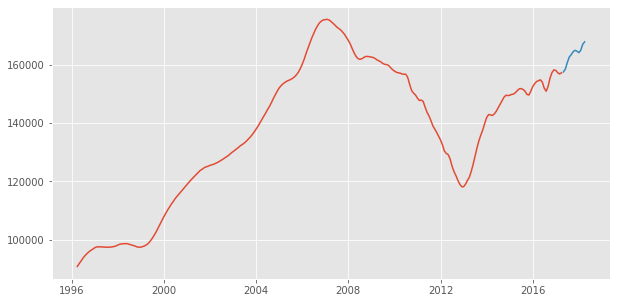

In [103]:
fig = plt.figure(figsize=(10,5))
aurora_train = aurora.iloc[0:253]
aurora_test = aurora.iloc[253:]
plt.plot(aurora_train)
plt.plot(aurora_test)
plt.show()

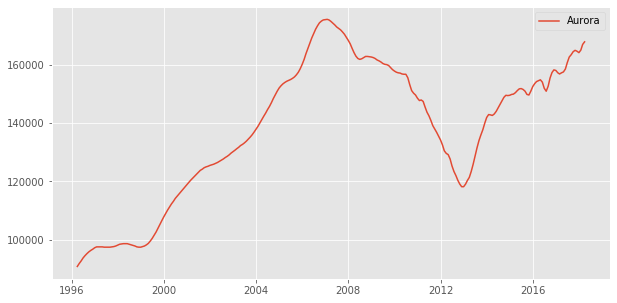

In [104]:
# Check it against original data
plt.figure(figsize=(10,5))
plt.plot(aurora)
plt.legend(aurora.columns)
plt.show()

### Run Auto ARIMA

In [105]:
aurora_auto_arima_train = auto_arima(aurora_train,
                               start_p=0, d=None, start_q=0,
                               max_p=4, max_d=5, max_q=5,
                               suppress_warnings=True, trace=True, stepwise=False, n_fits=20)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=4184.919, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=4155.805, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=4146.206, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=4131.052, Time=0.42 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=4125.162, Time=0.45 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=4127.912, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=4148.569, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=4099.722, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=4132.605, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=4112.947, Time=1.20 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=4118.445, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=4130.036, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=4155.944, Time=1.00 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=4158.701, Time=1.82 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=4233.780, Time=1.10 sec
 ARIMA(3,1

#### Check the model

In [106]:
aurora_output = aurora_auto_arima_train.fit(aurora_train)

print(aurora_output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.7871     12.041      2.059      0.040       1.188      48.386
ar.L1          0.8305      0.027     31.280      0.000       0.778       0.883
ma.L1         -0.7221      0.031    -23.194      0.000      -0.783      -0.661
sigma2      5.021e+05   3.38e+04     14.841      0.000    4.36e+05    5.68e+05


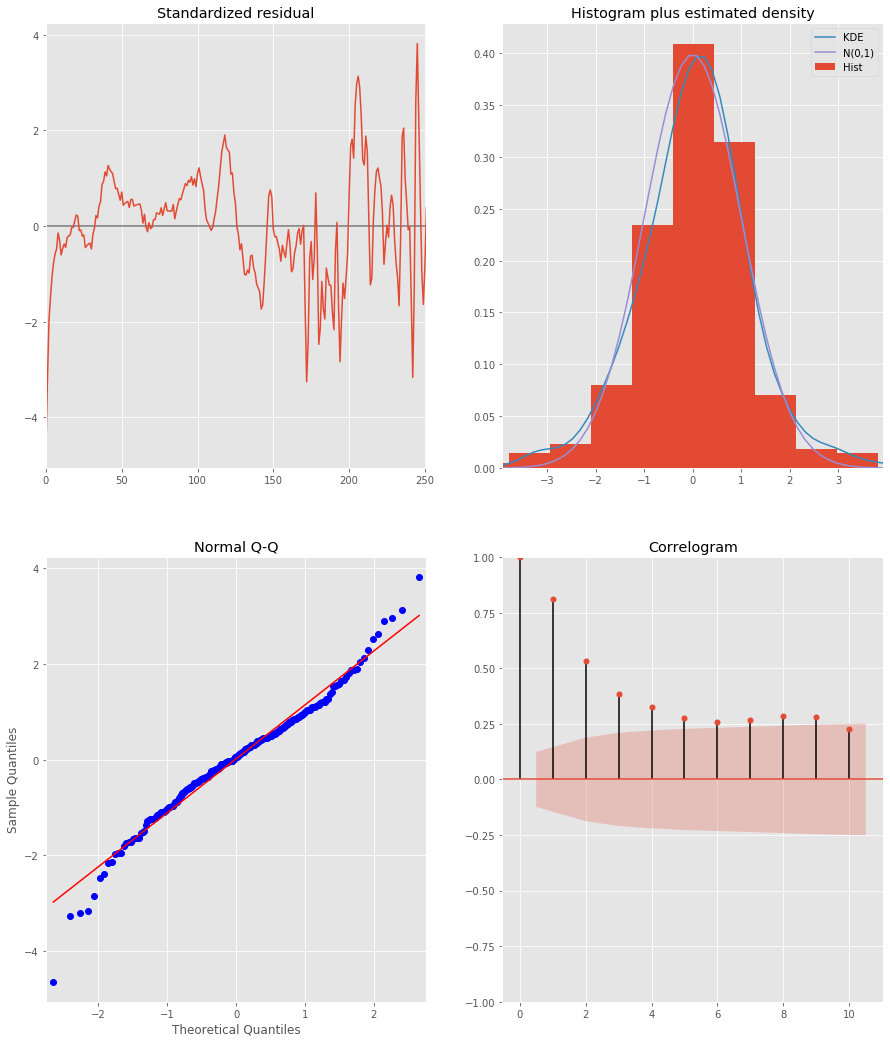

In [107]:
aurora_output.plot_diagnostics(figsize=(15, 18))
plt.show()

This one looks like the best fit yet.

#### SARIMAX for increased functionality

C:\Users\halpe\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8487      0.024     34.812      0.000       0.801       0.896
ma.L1         -0.7415      0.029    -25.457      0.000      -0.799      -0.684
sigma2      5.026e+05   3.32e+04     15.122      0.000    4.37e+05    5.68e+05


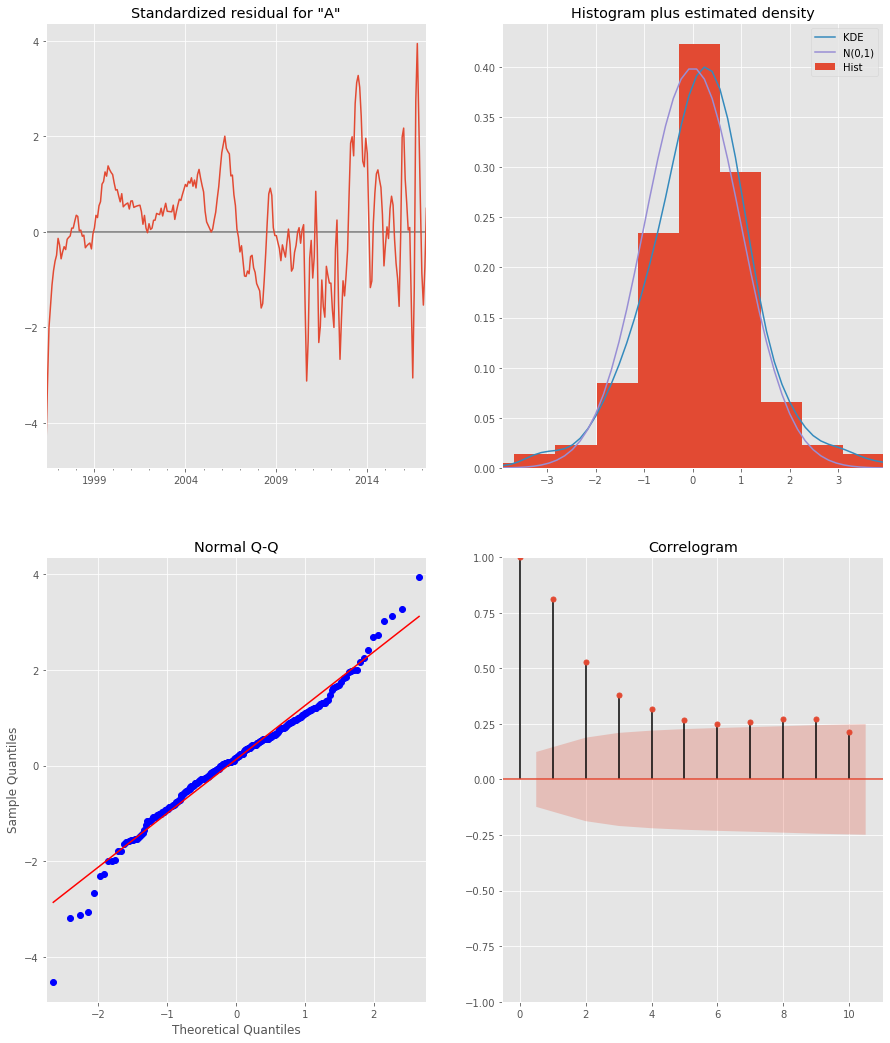

In [109]:
aurora_arima_smx = sm.tsa.statespace.SARIMAX(aurora_train,
                                      order=(1,1,1), 
                                      freq='MS',
                                      enforce_stationarity=True, 
                                      enforce_invertibility=False)
aurora_output = aurora_arima_smx.fit()
print(aurora_output.summary().tables[1])

aurora_output.plot_diagnostics(figsize=(15, 18))
plt.show()

## Validating the model

### Forecasting

In [110]:
pred = aurora_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_conf = pred.conf_int()

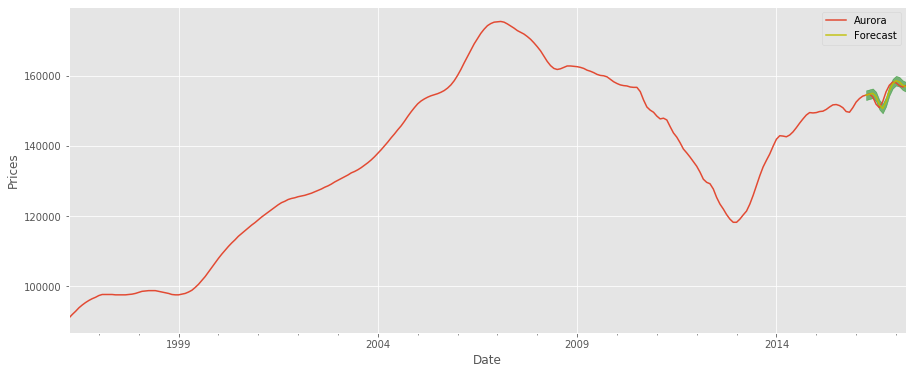

In [111]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aurora_train.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.9, color='y')

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

The yellow line shows a pretty good fit with a higher confidence interval. 

In [112]:
# RMSE
aurora_train_forecasted = pred.predicted_mean
aurora_train_truth = aurora_train['2016-04-01':]

rms = mean_squared_error(aurora_train_truth, aurora_train_forecasted, squared=False)
round(rms, 2)

1320.68

### Dynamic Forecasting

In [113]:
aurora_output

In [114]:
pred_dynamic = aurora_output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [115]:
aurora_train_forecasted = pred_dynamic.predicted_mean
aurora_train_truth = aurora_train['2016-04-01':]

rms = mean_squared_error(aurora_train_truth, aurora_train_forecasted, squared=False)
round(rms, 2)

2106.08

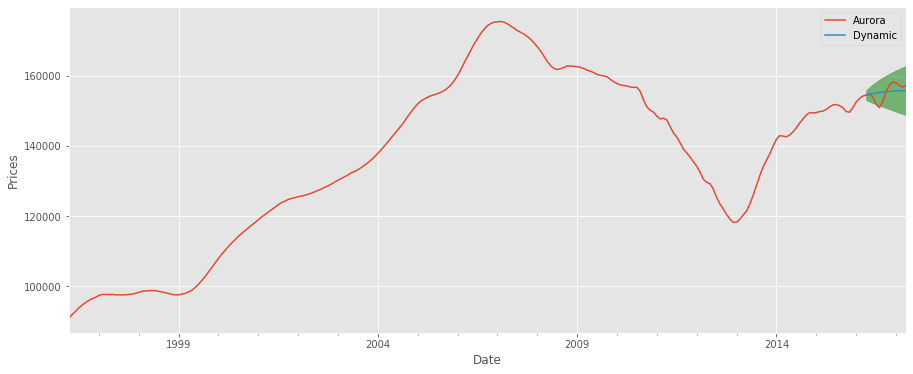

In [116]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aurora_train.plot(label='aurora')

# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic')

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Prices')
plt.legend()

plt.show()

Dynamic forecast is well in range.

### RMSE

In [117]:
# RMSE on the Forecasted (not dynamic) to compare with test set
forecast = aurora_output.forecast(steps=12)

rms = mean_squared_error(aurora_test, forecast, squared=False)
round(rms, 2)

6509.78

## Producing Forecasts

In [118]:
# Get forecast 24 steps ahead in future
prediction = aurora_output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

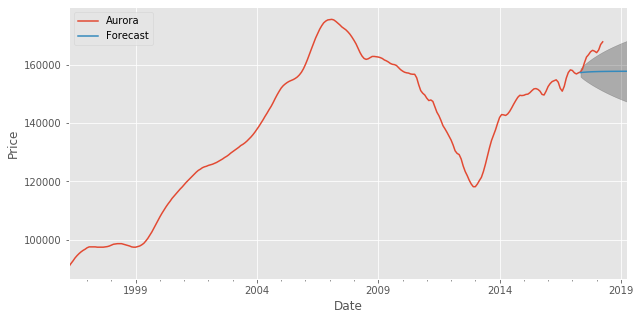

In [119]:
ax = aurora.plot(label='observed', figsize=(10,5))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

The dynamic forecast here is not good. Only using train set and predicting farther in advance than previous dynamic plot.